In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from numpy import mean, std
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix


In [9]:
data = pd.read_csv(r'cumulative.csv', sep=',', comment='#')
data 

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,93.59,35.8,1.0,q1_q17_dr25_tce,5455.0,4.467,0.927,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,9.11,25.8,2.0,q1_q17_dr25_tce,5455.0,4.467,0.927,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,39.30,76.3,1.0,q1_q17_dr25_tce,5853.0,4.544,0.868,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,891.96,505.6,1.0,q1_q17_dr25_tce,5805.0,4.564,0.791,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,926.16,40.9,1.0,q1_q17_dr25_tce,6031.0,4.438,1.046,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,10090151,K07985.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,0,...,4500.53,453.3,1.0,q1_q17_dr25_tce,5638.0,4.529,0.903,297.18875,47.093819,14.082
9560,10128825,K07986.01,NaN,CANDIDATE,CANDIDATE,0.497,0,0,0,0,...,1585.81,10.6,1.0,q1_q17_dr25_tce,6119.0,4.444,1.031,286.50937,47.163219,14.757
9561,10147276,K07987.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.021,0,0,1,0,...,5713.41,12.3,1.0,q1_q17_dr25_tce,6173.0,4.447,1.041,294.16489,47.176281,15.385
9562,10155286,K07988.01,NaN,CANDIDATE,CANDIDATE,0.092,0,0,0,0,...,22.68,14.0,1.0,q1_q17_dr25_tce,4989.0,2.992,7.824,296.76288,47.145142,10.998


In [10]:
data_cleaned = data.drop(['kepid', 'kepoi_name', 'kepler_name','koi_pdisposition', 'koi_score'], axis=1)
data_cleaned

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,...,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,9.488036,170.538750,0.146,2.95750,615.8,...,93.59,35.8,1.0,q1_q17_dr25_tce,5455.0,4.467,0.927,291.93423,48.141651,15.347
1,CONFIRMED,0,0,0,0,54.418383,162.513840,0.586,4.50700,874.8,...,9.11,25.8,2.0,q1_q17_dr25_tce,5455.0,4.467,0.927,291.93423,48.141651,15.347
2,CANDIDATE,0,0,0,0,19.899140,175.850252,0.969,1.78220,10829.0,...,39.30,76.3,1.0,q1_q17_dr25_tce,5853.0,4.544,0.868,297.00482,48.134129,15.436
3,FALSE POSITIVE,0,1,0,0,1.736952,170.307565,1.276,2.40641,8079.2,...,891.96,505.6,1.0,q1_q17_dr25_tce,5805.0,4.564,0.791,285.53461,48.285210,15.597
4,CONFIRMED,0,0,0,0,2.525592,171.595550,0.701,1.65450,603.3,...,926.16,40.9,1.0,q1_q17_dr25_tce,6031.0,4.438,1.046,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,FALSE POSITIVE,0,1,1,0,0.527699,131.705093,1.252,3.22210,1579.2,...,4500.53,453.3,1.0,q1_q17_dr25_tce,5638.0,4.529,0.903,297.18875,47.093819,14.082
9560,CANDIDATE,0,0,0,0,1.739849,133.001270,0.043,3.11400,48.5,...,1585.81,10.6,1.0,q1_q17_dr25_tce,6119.0,4.444,1.031,286.50937,47.163219,14.757
9561,FALSE POSITIVE,0,0,1,0,0.681402,132.181750,0.147,0.86500,103.6,...,5713.41,12.3,1.0,q1_q17_dr25_tce,6173.0,4.447,1.041,294.16489,47.176281,15.385
9562,CANDIDATE,0,0,0,0,333.486169,153.615010,0.214,3.19900,639.1,...,22.68,14.0,1.0,q1_q17_dr25_tce,4989.0,2.992,7.824,296.76288,47.145142,10.998


In [11]:
# Limit target values to CANDIDATE and CONFIRMED
false_positive_rows = data_cleaned.query("koi_disposition == 'FALSE POSITIVE'").index
df = data_cleaned.drop(false_positive_rows, axis=0).reset_index(drop=True)

#Transforming target column in binary data
df['koi_disposition'] = df['koi_disposition'].map({"CANDIDATE":1,"CONFIRMED":0})
    
# Drop columns with all missing values
df = df.drop(['koi_teq_err1', 'koi_teq_err2'], axis=1)

# Fill remaining missing values
df['koi_tce_delivname'] = df['koi_tce_delivname'].fillna(df['koi_tce_delivname'].mode()[0])

# Fill only numeric columns with mean
for column in df.columns[df.isna().sum() > 0]:
    if df[column].dtype in ['float64', 'int64', 'float32', 'int32']:
        df[column] = df[column].fillna(df[column].mean())
    else:
        # For non-numeric columns, use mode or a placeholder
        df[column] = df[column].fillna(df[column].mode()[0] if not df[column].mode().empty else 'Unknown')


KeyError: "['koi_teq_err1', 'koi_teq_err2'] not found in axis"

In [ ]:
# One-hot encode koi_tce_delivname column
delivname_dummies = pd.get_dummies(df['koi_tce_delivname'], prefix='delivname')
df = pd.concat([df, delivname_dummies], axis=1)
df = df.drop('koi_tce_delivname', axis=1)

# Split df into X and y
y = df['koi_disposition'].astype(float)
X = df.drop('koi_disposition', axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

# Scale X
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
X_train, X_test, y_train, y_test

(      koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  koi_period  \
 4239        -0.0348      -0.055073            0.0            0.0    0.020484   
 154         -0.0348      -0.055073            0.0            0.0   -0.037493   
 476         -0.0348      -0.055073            0.0            0.0   -0.008967   
 4428        -0.0348      -0.055073            0.0            0.0   -0.040032   
 81          -0.0348      -0.055073            0.0            0.0   -0.041046   
 ...             ...            ...            ...            ...         ...   
 2895        -0.0348      -0.055073            0.0            0.0   -0.041623   
 2763        -0.0348      -0.055073            0.0            0.0    0.117424   
 905         -0.0348      -0.055073            0.0            0.0   -0.028726   
 3980        -0.0348      -0.055073            0.0            0.0   -0.039697   
 235         -0.0348      -0.055073            0.0            0.0   -0.042497   
 
       koi_period_err1  ko

In [ ]:
#Applying random forest classifier
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
def classification_report(y_test, y_pred, positive_label=1):
    tp = 0
    fn= 0
    fp = 0
    tn = 0
    for i, j in zip(y_test, y_pred):
        if i == positive_label:
            if j == positive_label:
                tp += 1
            else:
                fn += 1
        else:
            if j == positive_label:
                fp += 1
            else:
                tn += 1
    return tp, fn, fp, tn

def accuracy(tp, fn, fp, tn):
    return (tp + tn) / (tp + fn + fp + tn)

def precision(tp, fn, fp, tn):
    return tp / (tp + fp)

def recall(tp, fn, fp, tn):
    return tp / (tp + fn)

def f1_score(tp, fn, fp, tn):
    Precision = precision(tp, fn, fp, tn)
    Recall = recall(tp, fn, fp, tn)
    F1_score = 2 * (Precision * Recall) / (Precision + Recall)
    return F1_score

def sensitivity(tp, fn, fp, tn):
    Sensitivity = tp / (tp + fn)
    return Sensitivity

def specificity(tp, fn, fp, tn):
    Specificity = tn / (tn + fp)
    return Specificity


In [ ]:
np.random.seed(0)

In [ ]:
start_time = time.time()

In [ ]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(classifier, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('Accuracy: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))

[0.89217759 0.86046512 0.86469345 0.86257928 0.85623679 0.87076271
 0.87076271 0.88135593 0.88983051 0.89830508 0.86680761 0.88794926
 0.86046512 0.87315011 0.85412262 0.87288136 0.90042373 0.87711864
 0.88135593 0.86440678 0.86469345 0.86680761 0.86892178 0.84566596
 0.88794926 0.86864407 0.89618644 0.87923729 0.87711864 0.86864407
 0.84566596 0.87315011 0.87526427 0.90063425 0.87737844 0.875
 0.8940678  0.875      0.88771186 0.86440678 0.8794926  0.90274841
 0.87737844 0.89006342 0.88372093 0.84957627 0.88347458 0.88347458
 0.86228814 0.84322034]
Accuracy: 0.8747 (0.0146)


In [ ]:


# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(classifier, X, y, scoring='recall', cv=cv, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('sensitivity: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))



[0.84343434 0.83333333 0.83333333 0.85858586 0.80808081 0.83756345
 0.83838384 0.83838384 0.82828283 0.88383838 0.82323232 0.83333333
 0.80808081 0.83838384 0.81313131 0.8071066  0.87373737 0.88888889
 0.85353535 0.80808081 0.82828283 0.81818182 0.85858586 0.84848485
 0.83333333 0.83248731 0.87878788 0.84343434 0.81313131 0.83333333
 0.84343434 0.84848485 0.82828283 0.87878788 0.82323232 0.83248731
 0.86363636 0.81818182 0.82828283 0.81818182 0.82323232 0.89393939
 0.84848485 0.83333333 0.83333333 0.83756345 0.83838384 0.86868687
 0.87373737 0.76262626]
sensitivity: 0.8387 (0.0244)


In [ ]:
specificity = make_scorer(recall_score, pos_label=0)

In [ ]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(classifier, X, y, cv=cv, scoring = specificity, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('specificity: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))

[0.94181818 0.88727273 0.88       0.90545455 0.90545455 0.89454545
 0.88686131 0.93430657 0.91970803 0.88321168 0.88727273 0.91636364
 0.88363636 0.88727273 0.87636364 0.93090909 0.91605839 0.88321168
 0.88686131 0.92335766 0.90909091 0.89090909 0.88       0.85454545
 0.93454545 0.89090909 0.91240876 0.91240876 0.9379562  0.90510949
 0.85090909 0.86545455 0.90545455 0.92       0.92       0.91272727
 0.90510949 0.90875912 0.93065693 0.90875912 0.90909091 0.90909091
 0.91636364 0.90909091 0.90181818 0.88       0.91970803 0.87956204
 0.87956204 0.90145985]
specificity: 0.9018 (0.0207)


In [ ]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(classifier, X, y, scoring='precision', cv=cv, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('precision: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))

[0.89304813 0.84375    0.83417085 0.85858586 0.88268156 0.84693878
 0.85204082 0.89784946 0.89673913 0.865      0.85789474 0.88709677
 0.84042553 0.835      0.84536082 0.88333333 0.88944724 0.84057971
 0.85572139 0.87431694 0.85263158 0.84974093 0.83663366 0.78504673
 0.88586957 0.85279188 0.89393939 0.86458333 0.90340909 0.86772487
 0.80193237 0.81642512 0.87434555 0.91005291 0.87567568 0.85051546
 0.88265306 0.87096774 0.89617486 0.86666667 0.88770053 0.86057692
 0.87765957 0.87301587 0.87434555 0.83163265 0.875      0.85643564
 0.83009709 0.86516854]
precision: 0.8630 (0.0257)


In [ ]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('f1 score: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))

[0.87434555 0.81958763 0.83291771 0.84050633 0.83989501 0.84536082
 0.84848485 0.86387435 0.87113402 0.87064677 0.83589744 0.85639687
 0.83290488 0.83756345 0.81841432 0.84126984 0.88832487 0.85784314
 0.85642317 0.83684211 0.84536082 0.83589744 0.84924623 0.8195122
 0.86387435 0.8346056  0.8989899  0.86082474 0.85941645 0.84675325
 0.81372549 0.84367246 0.84536082 0.87468031 0.85941645 0.84398977
 0.87179487 0.85128205 0.86910995 0.83246073 0.83419689 0.88833747
 0.83854167 0.86082474 0.85128205 0.83919598 0.8556701  0.86352357
 0.84444444 0.80533333]
f1 score: 0.8494 (0.0192)


In [ ]:
#Print Time
print("--- %s seconds ---" % (time.time() - start_time))

--- 165.68277168273926 seconds ---


In [ ]:
y_pred = classifier.predict(X_test)
print(" Accuracy: {:.3f}%".format(accuracy(*classification_report(y_test, y_pred)) * 100))

 Accuracy: 87.588%


In [ ]:
y_pred = classifier.predict(X_test)
print(" Sensitivity: {:.3f}%".format(sensitivity(*classification_report(y_test, y_pred)) * 100))

 Sensitivity: 84.757%


In [ ]:
y_pred = classifier.predict(X_test)
print(" Precision: {:.3f}%".format(precision(*classification_report(y_test, y_pred)) * 100))

 Precision: 85.618%


In [ ]:
y_pred = classifier.predict(X_test)
print(" F1 Score: {:.3f}%".format(f1_score(*classification_report(y_test, y_pred)) * 100))

 F1 Score: 85.185%


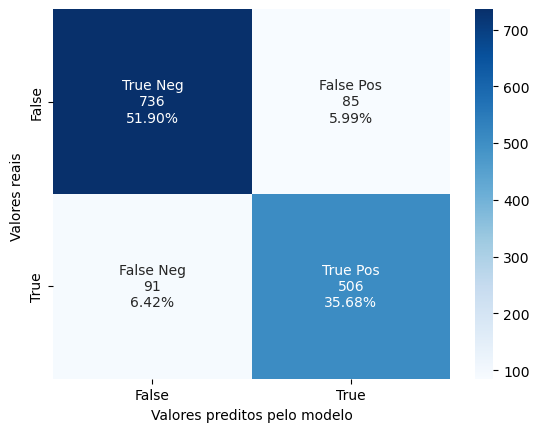

In [ ]:
y_pred = classifier.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

#ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('Valores preditos pelo modelo')
ax.set_ylabel('Valores reais ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.savefig('my_plot.JPEG')
plt.show()